In [262]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [263]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [264]:
sys.path.insert(0, os.path.abspath('../palin/python'))

In [284]:
#from palin.simulation import Experiment
from palin.simulation.experiment import Experiment
from palin.simulation.analyser import Analyser
from palin.simulation.experiments.simple_experiment import SimpleExperiment
from palin.simulation.experiments.double_pass_experiment import DoublePassExperiment
from palin.simulation.trial import Int2Trial, Int1Trial 
from palin.simulation.observers.linear_observer import LinearObserver
from palin.simulation.analysers.kernel_distance import KernelDistance
from palin.simulation.analysers.internal_noise_value import InternalNoiseValue
from palin.kernels.classification_images import ClassificationImage
from palin.internal_noise.double_pass import DoublePass
from palin.internal_noise.intercept_method import InterceptMethod
from palin.simulation.simulation import Simulation as Sim
from palin.simulation.analysers.agreement_statistics import AgreementStatistics
from palin.internal_noise.agreement_method import AgreementMethod
from palin.kernels.glm_kernel import GLMKernel
from palin.internal_noise.glm_method import GLMMethod


## A quick palin tutorial

### General architecture

This is the general palin simulation structure: 
- we create an Experiment (here, a `DoublePassExperiment`, with 1000 2AFC trials + repeat the last 1000, i.e. 2000 trials on the whole). Experiments are subclasses of the `Experiment` abstract class, for now 2 are implemented: `SimpleExperiment` and `DoublePassExperiment` 
- we create an Observer (here, a LinearObserver with kernel, internal_noise, and bias/criteria). Again, Observer classes are subclasses of the basic `Observer` class (we have `LinearObserver`, but we could also have `PerseveratingObserver`, etc.) 
- we let the observer respond to the experiment, by `obs.respond_to_experiment(exp)`. This generates a list of responses (here, 0,1,0,0,0,1,1, etc...). Obviously if there are sources of stochasticity (e.g. the observer has non-zero internal_noise), every call to `respond` will generate different responses
- there is a utility in the `Analyser` class (read more about Analysers below) to gather the info about each of the `exp` trials + their corresponding response into a single dataframe (`to_df(exp, responses)`)

In [266]:
exp = DoublePassExperiment(n_trials = 1000,n_repeated=1000, 
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = 3, 
                                        criteria = 0)
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)

In [267]:
responses_df.head(12)

,trial,stim,feature,value,response
0,0,0,0,-99.126867,False
1,0,0,1,45.106065,False
2,0,0,2,32.093750,False
3,0,0,3,-117.816852,False
4,0,0,4,2.509503,False
5,0,0,5,100.494772,False
6,0,1,0,29.051973,True
7,0,1,1,-94.993202,True
8,0,1,2,-52.089931,True
9,0,1,3,110.265948,True


### Simulation object

Palin also gets you a `Simulation`object, which allows to have many different instances of `Observer` meet many different instances of `Experiment`, and run an automated `Analyser` on the result. (essentially, `Simulation.run()` calls 
```
responses = obs.respond_to_experiment(exp)
values = ana.analyse(exp, obs, responses)
``` 
`Simulations` are created by passing: 
- a class of `Observer`(e.g. here, `LinearObserver`), as well as parameters `observer_params` that should be used to construct them, in the form of a dict. For instance, creating a simulation with 
```
observer_params = {'kernel':[[0,0,0,0,0]]
                   'internal_noise_std':np.arange(0,5.1,1), 
                   'criteria':[0]}
```
means the simulation will create 5 different instances of `LinearObserver`, each with the same kernel ([0,0,0,0,0]) and criteria (0) but each with their own internal_noise from 0 to 5, i.e. the simulation will look at how observer's internal noise affects the analysis. Note that, if specific kernels are not important, the keyword `'random'` allows to create observers with random kernels (calling the class method `LinearObserver.with_random_kernel()`): 
```
observer_params = {'kernel':['random'],[...]
```
- a class of `Experiment` with their parameters `experiment_params`. For instance, passing `DoublePassExperiment` with 
```
experiment_params = {'n_trials':[150,300,500], 
                     'n_repeated':[500], # note: this will create min(n_trial,n_repeated) repeated trials 
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
```
will create 3 double-pass experiments (resp. with 150+150, 200+200, 500+500 trials), of the type 2AFC (`Int2Trial`), where stimuli are 5 dimensional, randomly sampled with a std of 100.  
- a class of `Analyser` with their parameters `analyser_params`. For instance, if you pass 
```
analyser_params = {'internal_noise_extractor':[DoublePass],
                   'model_file':['large_model.csv']}     
sim = Sim([...], InternalNoiseValue, analyser_params)
```
the simulation will have every observer meet every experiment, and on each response run an `InternalNoiseValue` analyser. This `Analyser` takes 2 parameters: an internal noise estimation method (here, `DoublePass`, which is a subclass of the generic  `InternalNoiseExtractor`) and the parameters of that method (here, a pre-learned model, built with `DoublePass.build_model()`)  
When the simulation is run (`Simulation.run_all(n_runs)`), the Simulation will iterate for every configuration in `observer_params`,`experiment_params`, `analyser_params` and have every possible observer meet every possible experiment, let `obs.respond_to_experiment(exp)`, run every possible analyser on the result (we call the combination of a specific obs, exp and ana a "configuration"), and return the result as a big dataframe where each line describes a configuration + their result. The `n_runs` parameter allows to run each configuration n times (e.g. to compute confidence intervals on analyser results when configuration have internal stochasticity). 

The combinatorial nature of simulations (nb of obs * nb of experiments * nb of analysers * n_runs) quickly create thousands of configurations. For optimization, simulations are implemented in multiple threads, where each configuration is computed in parallel. 

In [269]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[150,300,500], 
                     'n_repeated':[500], # note: this will create min(n_trial,n_repeated) repeated trials 
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[DoublePass],
                   'agreement_model_file':['agreement_model_large.csv']}        
                   
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)
sim_df = sim.run_all(n_runs=10)


100%|██████████| 1530/1530 [02:54<00:00,  8.75it/s]


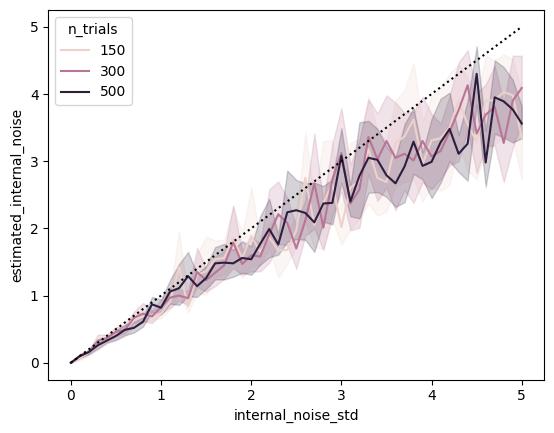

In [270]:
sns.lineplot(data=sim_df, 
            x='internal_noise_std',hue='n_trials',
            y='estimated_internal_noise')
plt.plot([0,5],[0,5],'k:')

### Analysers and extractors

Palin has a double purpose: 
- first, provide a selection of methods to extract kernels and internal noise from reverse-correlation data
- second, provide a Simulation API to test and compare these methods

Code for these two purposes is essentially separated: the former methods are stored in `palin.kernels` and `palin.internal_noise`: kernel extractors are subclasses of `KernelExtractor`, and include, say, `classificationImage`. internal noise extractors are subclasses of `InternalNoiseExtractor` and include, e.g., `DoublePass`. 

Each of these methods can be called directly on experimental or simulation data, e.g. 
```
DoublePass.extract_single_internal_noise(responses_df, agreement_model_file='agreement_model_large.csv')
```
will return the estimated internal noise and criteria from the simulated set of responses above

In [271]:
DoublePass.extract_single_internal_noise(responses_df, agreement_model_file='agreement_model_large.csv')

1.8

Code for simulation is stored in `palin.simulation` and includes implementations for subclasses of `Observers` (in `palin.simulation.observers`), `Experiments` (`palin.simulation.experiments`) and `Analysers` (`palin.simulation.analysers`). However, to avoid duplicating code, `Analysers` do not implement their own kernel, internal noise (or whatever) analysis method, but call the methods implemented in `palin.kernels` and `palin.internal_noise`. For instance, the `palin.simulation.analysers.InternalNoiseValue` analyser computes internal noise using an `InternalNoiseExtractor` given as argument. Calling 
```
InternalNoiseValue(internal_noise_extractor=DoublePass, agreement_model_file='agreement_model_large.csv').analyse(exp, obs, responses)
```
essentially calls 
```
responses_df = Analyser.to_df(exp, responses)
DoublePass.extract_single_internal_noise(responses_df, agreement_model_file='large_model.csv')
```

In [272]:
InternalNoiseValue(internal_noise_extractor=DoublePass, agreement_model_file='agreement_model_large.csv').analyse(exp, obs, responses)

[1.8]

Note we try to be consistent with words: _extractors_ are kernel and internal noise estimation methods (in `palin.kernels` and `palin.internal_noise`) that can be called e.g. on experimental data; _analysers_ encapsulate these extractors into objects called in simulations. Simple analysers such as `InternalNoiseValue(internal_noise_extractor)` may simply pass on the result of the extractor. More complex analysers may use the result of the extractor to do something different/more complex. For instance: 
- `AgreementStatistics` takes an internal_noise_extractor of the `AgreementMethod` family and, instead of internal noise values, returns the intermediate prob(agree) and prob(int1) statistics ("agreement statistics") that it uses to compute internal noise

In [273]:
AgreementStatistics(internal_noise_extractor=DoublePass).analyse(exp, obs, responses)

(0.618, 0.502)

- `KernelDistance` takes a `KernelExtractor`, applies it on responses data and, instead of returning that kernel, returns the distance of that estimated kernel to the true kernel (which is a parameter of the observer). 

In [274]:
# calling a Kernel extractor
ClassificationImage.extract_single_kernel(responses_df)

,kernel_value
feature,
0,41.931101
1,25.226151
2,7.437572
3,-4.459083
4,43.248264
5,-3.112178


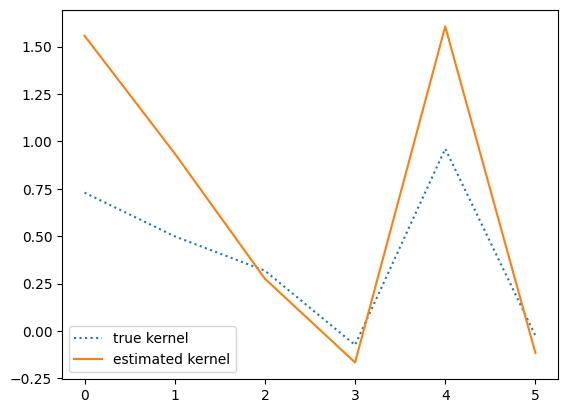

In [275]:
plt.plot(obs.kernel,':',label='true kernel')
plt.plot(ClassificationImage.normalize_kernel(ClassificationImage.extract_single_kernel(responses_df)),
         label='estimated kernel')
plt.legend()


In [276]:
# calling a KernelDistance analyser
KernelDistance(kernel_extractor=ClassificationImage, distance='CORR').analyse(exp, obs, responses)

[0.976006261809151]

`Extractors` called by `Analysers` is not the only place where `palin.kernels/internal_noise` and `palin.simulation`objects interact. Conversely, certain `Extractors` also call `Simulations` to do their job. For instance, the `AgreementMethod` family of internal noise extractors rely on simulating ideal observers with a range of internal noise and criteria values to match an observed measure of probability of agreement. This is done using a `Simulation` that computes the expected prob_agree and prob_int1 (i.e. `AgreementStatistics`) from observers having all possible values of internal noise and criteria: 

```
from ..simulation.observers.linear_observer import LinearObserver
from ..simulation.trial import Int2Trial 
from ..simulation.experiments.double_pass_experiment import DoublePassExperiment
from ..simulation.trial import Int2Trial, Int1Trial 
from ..simulation.analysers.agreement_statistics import AgreementStatistics
from ..simulation.simulation import Simulation as Sim
from .double_pass import DoublePass
        

        observer_params = {'kernel':[[1]],
                   'internal_noise_std':internal_noise_range, 
                  'criteria':criteria_range}
        experiment_params = {'n_trials':[n_repeated_trials],
                     'n_repeated':[n_repeated_trials],
                     'trial_type': [Int2Trial],
                     'n_features': [1],
                     'external_noise_std': [1]}
        analyser_params = {'internal_noise_extractor':[DoublePass]}

        ## TODO CHECK HOW to use AgreementStatistics instead of DoublePassStatistics here

        sim = Sim(DoublePassExperiment, experiment_params,
              LinearObserver, observer_params, 
              AgreementStatistics, analyser_params)

        sim_df = sim.run_all(n_runs=n_runs)
```

This is called by `AgreementMethod.build_model()`, and preferably done only once, stored in a model file, which is then passed as argument to the `DoublePass` extractor


In [277]:
model_df = AgreementMethod.build_model(agreement_model_file = 'agreement_model_small.csv', 
                                       internal_noise_range=np.arange(0,5,.1),
                                        criteria_range=np.arange(-5,5,1), 
                            #n_repeated_trials=10000, n_runs=5)
                            n_repeated_trials=100, n_runs=1)

Building double-pass model


100%|██████████| 500/500 [00:16<00:00, 30.29it/s]


Similarly, `GLMMethod` uses a regression model to convert a GLM's confidence interval to a value of internal noise, and pre-learns it with a `Simulation`. The model can be built with `GLMMethod.build_model()`, then passed as argument to the `GLMMethod` extractor methods. 

In [282]:
# build model
GLMMethod.build_model(glm_model_file='glm_model.pkl')
# use it 
GLMMethod.extract_single_internal_noise(responses_df, glm_model_file='glm_model.pkl')

100%|██████████| 4590/4590 [00:33<00:00, 137.54it/s]


1.5533342778585473

## Use simulation to compare internal noise methods

We'd like to compare the accuracy of several internal noise methods: the traditional double pass method: 

In [278]:
DoublePass.extract_single_internal_noise(responses_df, agreement_model_file='agreement_model_large.csv')
# or, alternatively
InternalNoiseValue(internal_noise_extractor=DoublePass, agreement_model_file='agreement_model_large.csv').analyse(exp, obs, responses)

[1.8]

with intercept methods (that come in 2 variants: either using a kernel_extractor or a None)

In [279]:
InterceptMethod.extract_single_internal_noise(responses_df, agreement_model_file='agreement_model_large.csv', kernel_extractor=None)
# or, alternatively
InternalNoiseValue(internal_noise_extractor=InterceptMethod, agreement_model_file='agreement_model_large.csv', kernel_extractor=None).analyse(exp, obs, responses)

[2.9000000000000004]

In [280]:
InterceptMethod.extract_single_internal_noise(responses_df, agreement_model_file='agreement_model_large.csv', kernel_extractor=ClassificationImage)
# or, alternatively
InternalNoiseValue(internal_noise_extractor=InterceptMethod, agreement_model_file='agreement_model_large.csv', kernel_extractor=ClassificationImage).analyse(exp, obs, responses)

[2.6]

and GLM methods

In [281]:
GLMMethod.extract_single_internal_noise(responses_df, glm_model_file='glm_model.pkl')
# or, alternatively
InternalNoiseValue(internal_noise_extractor=GLMMethod, glm_model_file='glm_model.pkl').analyse(exp, obs, responses)

[2.006264460903695]

To do that, we run a simulation testing all three types of analysers (more precisely, the `InternalNoiseValue` analyzer with all three parameters), on experiments with varying number of double pass trials (because that's expected to affect at least double-pass accuracy) and observers with varying degrees of internal noise. 

In [285]:
observer_params = {'kernel':['random'],#[[0,0,0,0,0]]
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':np.arange(100,1000,100), 
                     'n_repeated':[1000],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'internal_noise_extractor':[DoublePass,InterceptMethod, GLMMethod],
                   'kernel_extractor':[None,ClassificationImage],
                   'glm_model_file':['glm_model.pkl'],
                   'agreement_model_file':['agreement_model_large.csv']}        
                   
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)
sim_df = sim.run_all(n_runs=5)
sim_df.to_csv('./sim_internal_noise.csv')


100%|██████████| 13770/13770 [45:55<00:00,  5.00it/s]


Plot estimated internal noise vs true internal noise (baseline: diagonal line)

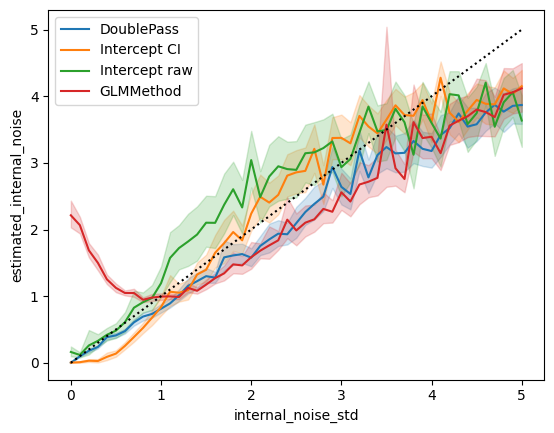

In [286]:
sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==DoublePass)&(sim_df.kernel_extractor.isna())], 
             x='internal_noise_std',
             y='estimated_internal_noise', label='DoublePass')
sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==InterceptMethod)
                         &(sim_df.kernel_extractor==ClassificationImage)], 
             x='internal_noise_std',
             y='estimated_internal_noise', label='Intercept CI')
sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==InterceptMethod)
                         &(sim_df.kernel_extractor.isna())], 
             x='internal_noise_std',
             y='estimated_internal_noise', label='Intercept raw')
sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==GLMMethod)
                         &(sim_df.kernel_extractor.isna())], 
             x='internal_noise_std',
             y='estimated_internal_noise', label='GLMMethod')

plt.plot([0,5],[0,5],'k:')

Plot absolute error (baseline: 0). Note that the error on the internal noise has a clear, diagonal shape cutoff in positive errors. This is because the model (`large_model.csv`) used in AgreementMethod estimates IN values between 0 and 5, and so the maximum positive error for internal_noise is |5-internal_noise| 

In [287]:
sim_df['internal_noise_error'] = sim_df.estimated_internal_noise - sim_df.internal_noise_std

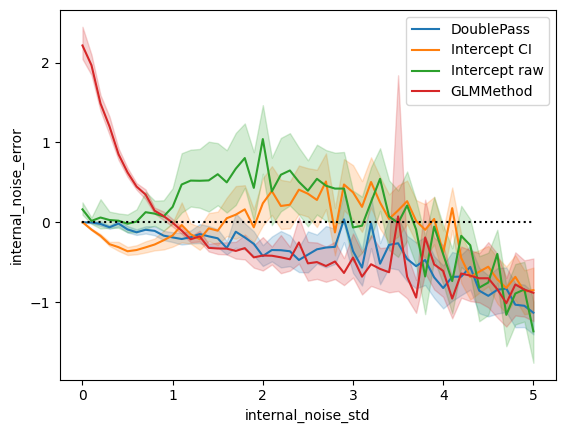

In [289]:
sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==DoublePass)&(sim_df.kernel_extractor.isna())], 
             x='internal_noise_std',
             y='internal_noise_error', label='DoublePass')
sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==InterceptMethod)
                         &(sim_df.kernel_extractor==ClassificationImage)], 
             x='internal_noise_std',
             y='internal_noise_error', label='Intercept CI')
sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==InterceptMethod)
                         &(sim_df.kernel_extractor.isna())], 
             x='internal_noise_std',
             y='internal_noise_error', label='Intercept raw')
sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==GLMMethod)
                         &(sim_df.kernel_extractor.isna())], 
             x='internal_noise_std',
             y='internal_noise_error', label='GLMMethod')

plt.plot([0,5],[0,0],'k:')
#plt.plot([0,4.9],[4.9,0],'k--')

Note that the error on the internal noise has a clear, diagonal shape cutoff in positive errors. This is because the model (`large_model.csv`) used in AgreementMethod estimates IN values between 0 and 5, and so the maximum positive error for internal_noise is |5-internal_noise| 

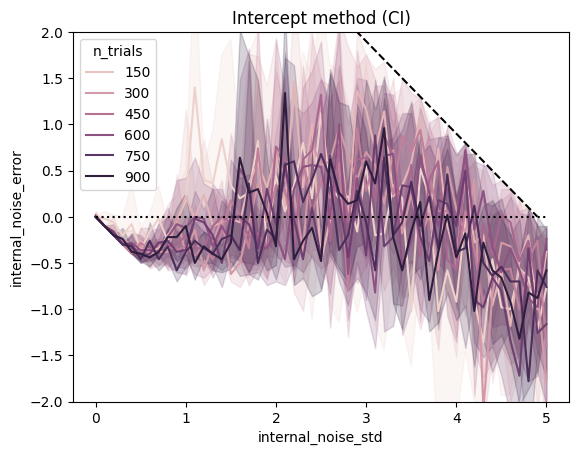

In [291]:
sns.lineplot(data=sim_df[(sim_df.internal_noise_extractor==InterceptMethod)
                         &(sim_df.kernel_extractor==ClassificationImage)], 
             x='internal_noise_std',hue='n_trials',
             y='internal_noise_error')
plt.title ('Intercept method (CI)')
plt.plot([0,5],[0,0],'k:')
plt.ylim([-2,2])
plt.plot([0,4.9],[4.9,0],'k--')